# Creating Morse Code Audio

I got my General Class license back when Morse Code was still a requirement. It's really not difficult to learn, and is a convenient way to send information. To examine some of the modulation techniques, I need some form of audio file. I made this notebook to generate audio files of arbitrary messaages in Morse Code.

In [1]:
### Useful modules, configuration for this notebook.

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf

plt.rcParams['font.size']=14

In [2]:
### Defining a dictionary for converting text to Morse. The dictionary will use the conventional - and . to indicate
#   the individual symbols for each character.

code = {'A':'.-', 'B':'-...', 'C':'-.-.', 'D':'-..', 'E':'.', 'F':'..-.', 'G':'--.', 'H':'....', 'I':'..', 'J':'.---', 'K':'-.-', 
        'L':'.-..', 'M':'--', 'N':'-.', 'O':'---', 'P':'.--.', 'Q':'--.-', 'R':'.-.', 'S':'...', 'T':'-', 'U':'..-', 'V':'...-', 
        'W':'.--', 'X':'-..-', 'Y':'-.--', 'Z':'--..', '1':'.----', '2':'..---', '3':'...--', '4':'....-', '5':'.....', 
        '6':'-....', '7':'--...', '8':'---..', '9':'----.', '0':'-----', '.':'.-.-.-', ',':'--..--', '?':'..--..', 
        ';':'-.-.-', ':':'---...', '/':'-..-.', '+':'.-.-.', '-':'-....-', '=':'-...-', '(':'-.--.', ')':'-.--.-', ' ':''}

## Functions

The mark() function creates an array of a sine wave for generating the audio.
  * freq: the frequency of the tone being used for a mark signal
  * length: the duration (in seconds) of the tone
  * fs: the sample frequency of the audio being generated
  * fadewidth: To minimize phase noise and clicking due to the abrupt changes at the edges of the sine wave, a cosine fade is applied. fadewidth provides the time in ms to apply the fade to.
  * time: Boolean flag to indicate whether the time array should also be returned. The time array is not used in building the audio file, so this is for testing purposes only.
  
The space() function creates and array of zeros for generating the gaps between tones in the audio.
  * length: the duration (in seconds) of the silence
  * fs: the sample frequency of the audio being generated
  * time: Boolean flag to indicate whether the time array should also be returned. The time array is not used in building the audio file, so this is for testing purposes only.
  
The build() function actually generates the complete waveform for the message being encoded.
  * message: ASCII text to encode
  * char_rate: the rate (in wpm) to produce the morse tones for individual characters.
  * word_rate: if using Farnsworth timing, set this to the rate at which words should be sent. If None, words are sent at char_rate.
  * fs: the sample frequency of the audio being generated
  * ft: the frequency of the tone to use in the audio
  * frontpad: Boolean flag to indicate whether some silence should be inserted at the front of the waveform. Adds padsize seconds at the front.
  * endpad: Boolean flag to indicate whether extra silence at the end of the waveform should be left. The extra silence resulting from the build() function automatically addinng 3 bit times at the end of every character is removed. If true, this adds padsize seconds back at the end. Always removing the last 3 farnsworth times lets us have direct control over the amount of silence at the front and back of the waveform.
  * padsize: amount of pad to use on the ends. Default is 0.5 seconds.

In [3]:
def mark(freq,length,fs,fadewidth=2,time=False):
    t = np.arange(0,length,1/fs)
    y = np.sin(2*np.pi*freq*t)
    ramp = np.ones_like(t)
    
    n = int(fs*(fadewidth/1000))
    fade = (1-(np.cos(np.linspace(0,np.pi,n))))/2
    ramp[:n] *= fade
    ramp[-1*n:] *= fade[::-1]

    if time:
        return t,y*ramp
    else:
        return y*ramp
    
def space(length,fs,time=False):
    t = np.arange(0,length,1/fs)
    y = 0*t
    if time:
        return t,y
    else:
        return y

def build(message, char_rate, word_rate=None, fs=48000, ft=700, frontpad=False, endpad=False, padsize=0.5):
    
    if char_rate < word_rate:
        print("Character speed must be at least the effective word speed.")
        return None
    
    if np.array([c.upper() not in code.keys() for c in message]).any():
        print("Message contains unsupported chracters.")
        return None
    
    word_bittime = 6./5./word_rate
    char_bittime = 6./5./char_rate
    
    timing = {'.':1*char_bittime, '-':3*char_bittime}
    
    signal = np.array([])
    if frontpad:                # Pad the front with some extra time. 
        signal = np.concatenate([signal,space(padsize,fs)])
        
    for c in message:
        if word_rate is None or char_rate==word_rate:
            if c==' ':
                signal = np.concatenate([signal,space(4*char_bittime,fs)])   # 3 of the space timings are already done from the previous character
            else:
                for e in code[c.upper()]:
                    signal = np.concatenate([signal,mark(ft,timing[e],fs)])
                    signal = np.concatenate([signal,space(char_bittime,fs)])
                signal = np.concatenate([signal,space(2*char_bittime,fs)])
        else:
            farns = (60-31*word_rate*char_bittime)/(19*word_rate)
            if c == ' ':
                signal = np.concatenate([signal,space(4*farns,fs)])
            else:
                for e in code[c.upper()]:
                    signal = np.concatenate([signal,mark(ft,timing[e],fs)])
                    signal = np.concatenate([signal,space(char_bittime,fs)])
                signal = np.concatenate([signal,space(3*farns-char_bittime,fs)])

    if word_rate is None or char_rate==word_rate:
        back = space(3*char_bittime,fs)
    else:
        back = space(3*farns,fs)    # Remove the last extraneous 3(2) farnsworth(bit) times
    signal = signal[:-1*len(back)]
    
    if endpad:
        signal = np.concatenate([signal,space(padsize,fs)])
        
    return signal


The mark() function applies a fade to each end of the tone. This removes "clicking" sounds from the audio and improves noise caused by the abrupt phase changes that would otherwise be present in the sharp edges. The plot below demonstrates what this fade looks like. A good reference to explain this feature is found at http://www.ivarc.org.uk/uploads/1/2/3/8/12380834/keyclicks_version_1.pdf. The pdf is present locally as well for convenience.

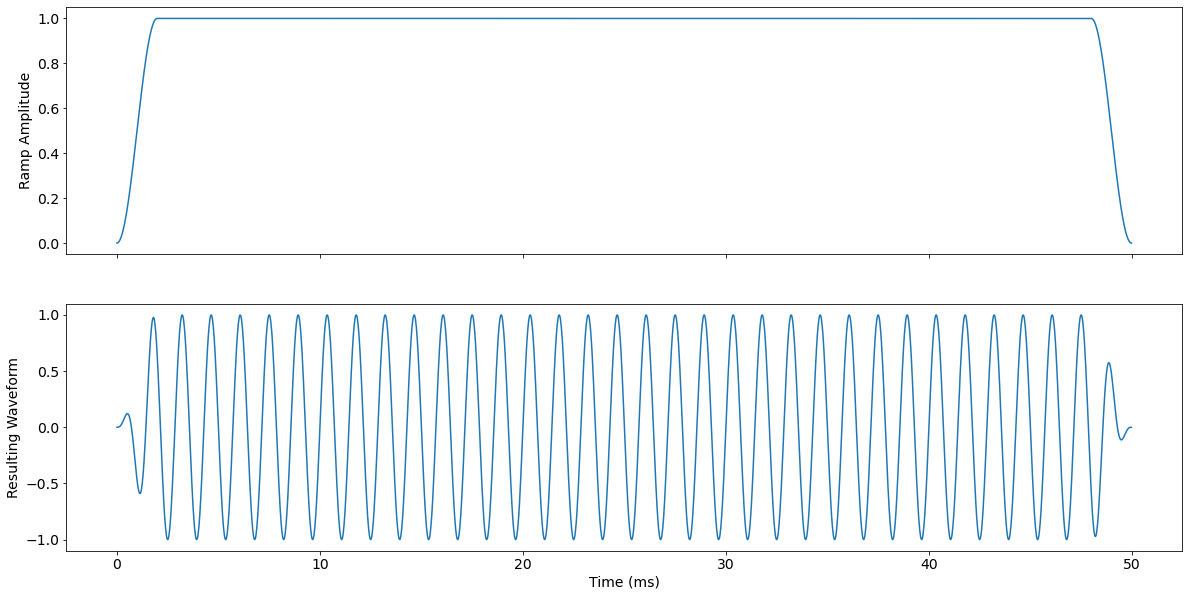

In [4]:
t,y = mark(700,0.05,48000,time=True)

ramp = np.ones_like(t)
n = int(48000*(2/1000))
fade = (1-(np.cos(np.linspace(0,np.pi,n))))/2
ramp[:n] *= fade
ramp[-1*n:] *= fade[::-1]

fig,ax = plt.subplots(2,1,figsize=(20,10),sharex=True)
ax[0].plot(t*1000,ramp)
ax[1].plot(t*1000,y)

ax[1].set_xlabel("Time (ms)")
ax[0].set_ylabel("Ramp Amplitude")
ax[1].set_ylabel("Resulting Waveform");

# Example

Here's an example waveform built from my call sign.

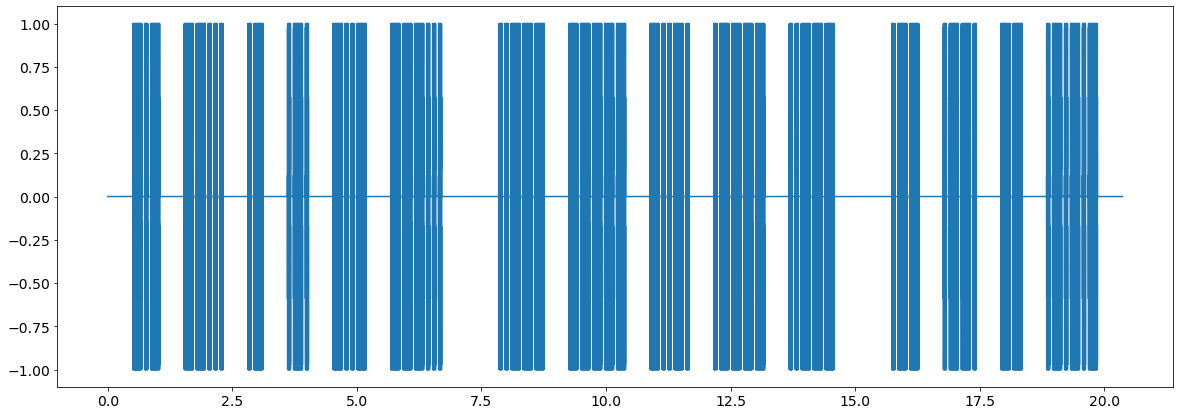

In [5]:
tone = 700
char_rate = 20 # wpm
word_rate = 12 # wpm
fs = 48000     # Use any convenient sample rate. Should be > 2*max audio frequency

signal = build('k7arx: 20/12 wpm.', char_rate, word_rate=word_rate, fs=fs, ft=tone, frontpad=True, endpad=True)
time = np.arange(0,len(signal)/fs,1/fs)[:len(signal)]

plt.figure(figsize=(20,7))
plt.plot(time,signal);

In [6]:
### Lets us resample the audio to standard audio sample rates. The waveform could have been built with this sample rate to begin with,
#   but I chose to use a non-standard rate to build the wave form so that I could demonstrate how to resample.

out_fs = 44100    # standard audio sampling rate
out_time = np.arange(0,time[-1],1/out_fs)   # Create the time base for the output signal
out_signal = np.interp(out_time,time,signal)
vol = 0.75    # a volume control if desired. Using 0.75 to prevent distortion in future experiments using this audio file.

sf.write("My_Morse_Packet.wav",vol*out_signal,out_fs)

# Decoding Morse Code Audio

Just for fun, let's build something to decode the audio file. We'll even add some noise to mimic a recording of live audio.

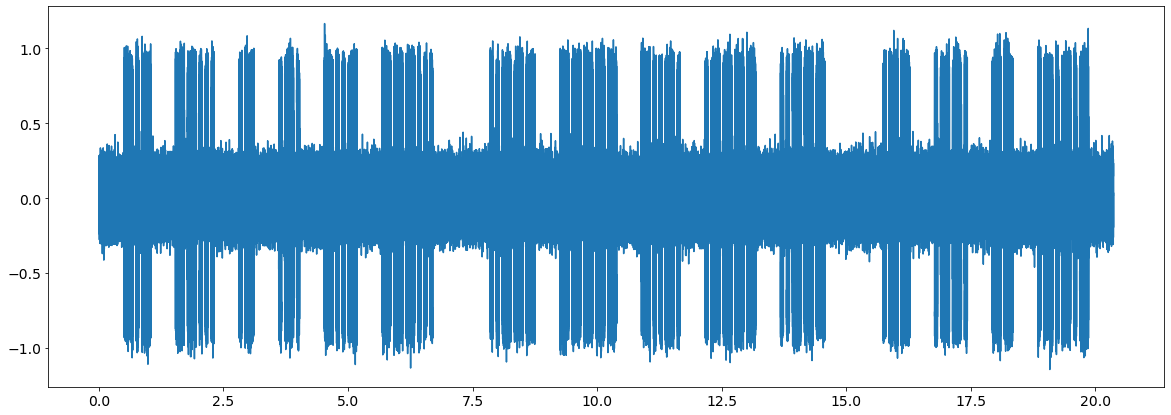

In [7]:
from scipy import signal as sg
np.random.normal

signal,fs = sf.read("My_Morse_Packet.wav")
time = np.arange(0,len(signal)/fs,1/fs)[:len(signal)]
signal += np.random.normal(scale=0.1,size=len(signal))
plt.figure(figsize=(20,7))
plt.plot(time,signal);

To extract the data, we need to pull out all the high frequency noise. To do this, we'll apply a low-pass butterworth filter. The filter will be 3-pole with a cutoff frequency at 2 kHz.

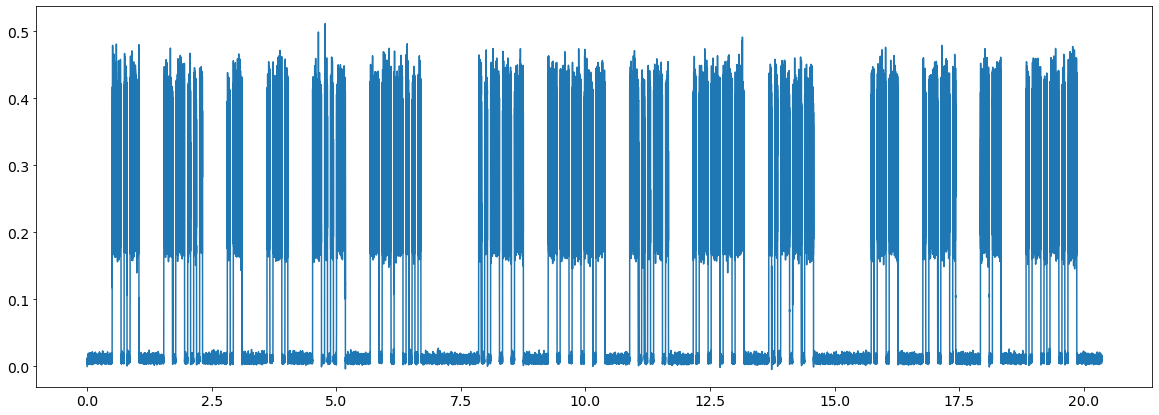

In [8]:
# Convert the signal into a bit sequence at the character rate
char_rate = 20  # wpm
char_bittime = 6./5./char_rate
bit_width = int(char_bittime*fs)

b,a = sg.butter(3,2000/fs)
filtered = sg.lfilter(b,a,signal**2)

plt.figure(figsize=(20,7))
plt.plot(time,filtered);

The presence of a signal, or "mark" state, is easily identified by selecting regions where the filtered signal is above 10% of its maximum value.

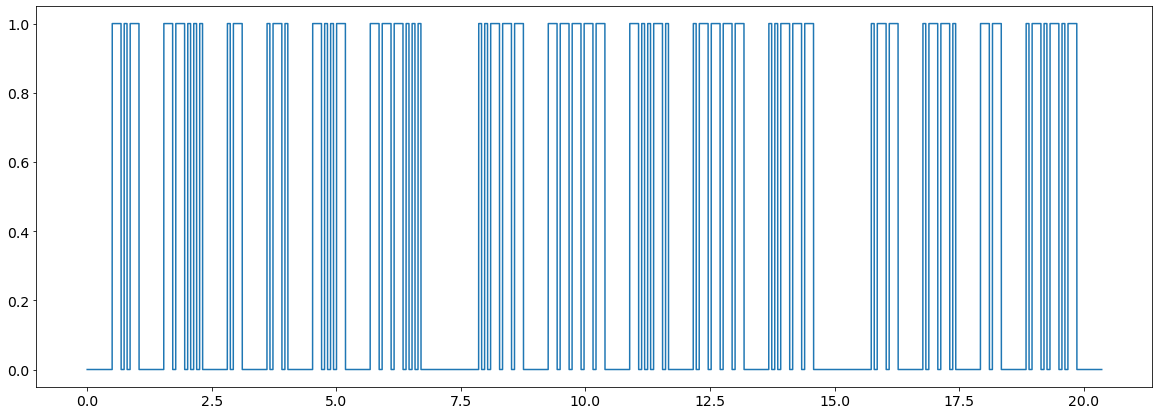

In [9]:
binary = (filtered>0.1*filtered.max()).astype(int)

plt.figure(figsize=(20,7))
plt.plot(time,binary);

The morse encoding is now clearly visible. We only need a routine to translate this back into text. To do that, we first need a new lookup that does the reverse of the encoding lookup -- one where the keys are '-' and '.' symbols, and the values are the corresponding text.

To do the actual decoding, we have a problem -- given the posibility that the recorded audio could have any combination of farnsworth timings, there is no way to be certain whether the lack of signal means next charcter, next word, or end of message. The easiest way around this problem is to use a state machine. This machine will have three states:
  * **listen**: no message yet -- this is to get through any initial space before the signal starts. We don't default to the space state because we don't want to keep track of how long the gap is before the message starts; it would throw off our differentiation between character and word gaps.
  * **mark**: signal is present -- starts timing the signal duration to distinguish between '.' and '-'. To do this, we need to assume a character rate. The code is actually quite robust to this, so anything reasonable to the actual rate should work.
  * **space**: signal has stopped -- starts timing the gap duration to distinguish between a character gap and a word gap.

In [10]:
rev_code = {}
for k,v in zip(code.keys(),code.values()):
    rev_code[v]=k

def decode(binary,char_rate):
    char_bittime = 6./5./char_rate
    state = 'listen'
    message = ''
    gaps = []
    i=0
    while i<len(binary):
        if state == 'mark':
            if not binary[i]:
                state = 'space'
                stop = i
                if time[stop]-time[start]>char_bittime*2:
                    message += '-'
                else:
                    message += '.'
                start = i
            i += 1
    
        elif state == 'space':
            if binary[i]:
                state = 'mark'
                stop = i
                if time[stop]-time[start]>char_bittime*2:
                    message += ' '
                    gaps.append(time[stop]-time[start])
                start = i
            i += 1
    
        else:
            if binary[i]:
                state = 'mark'
                start = i
            i += 1
        
    split = message.split()
    n = 1
    
    for i,g in enumerate(gaps>np.mean(gaps)*1.25):   # The 1.25 factor prevents false spaces for signals of a single word.
                                                     # As long as the spacing doesn't vary by more than 25%, this should
                                                     # be robust.
        if g:
            split.insert(i+n,'')
            n += 1
        
    return split

In [11]:
split = decode(binary,char_rate)
for s in split:
    print(rev_code[s],end='')

K7ARX: 20/12 WPM.